In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, LassoLarsCV, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.interpolate import UnivariateSpline
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian
from pygam import LinearGAM, s


Загрузка данных

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [4]:
train_df.head()

,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
0,896,2,0,46.0,3,5,0,0,0,0,...,2,3,0,7,3,13,2,7,18,2350000.0
1,399,2,0,44.6,5,5,0,0,0,0,...,3,5,0,7,3,11,1,4,11,1799000.0
2,1515,2,0,53.0,1,9,0,1,0,0,...,4,11,0,5,3,17,3,7,15,2800000.0
3,1216,2,0,64.0,4,5,0,0,0,1,...,31,5,1,55,2,10,28,32,17,3970000.0
4,677,1,0,33.3,1,10,0,0,1,0,...,1,3,0,2,3,9,0,3,6,1880000.0


In [5]:
test_df.head()

,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,...,Остановка.1000,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000
0,747,1,0,39.0,4,16,0,0,0,0,...,7,0,2,0,1,1,2,1,0,5
1,962,1,0,34.8,1,2,0,0,0,0,...,2,0,2,0,0,3,3,1,1,1
2,1105,1,0,37.7,2,17,0,0,0,0,...,5,2,9,0,9,3,17,4,2,13
3,795,4,0,83.5,10,10,0,0,0,0,...,13,47,5,1,19,2,11,2,13,20
4,390,1,0,42.0,10,10,0,0,0,0,...,20,8,8,0,7,2,18,6,6,17


In [5]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

## Предобработка

#### Проверка фиктивной переменной

In [15]:
wall_columns = ['Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Смешанные.стены']
wall_data_check = train_df[wall_columns].sum(axis=1)
print(wall_data_check.value_counts()) # во всех 808 строках равна 1

repair_columns = ['Без.ремонта', 'Дизайнерский', 'Евроремонт', 'Косметический']
repair_data_check = train_df[repair_columns].sum(axis=1)

print(repair_data_check.value_counts()) # во всех 808 строках равна 1


floor_type_columns = ['Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Иные.перекрытия']
floor_data_check = train_df[floor_type_columns].sum(axis=1)

print(floor_data_check.value_counts()) # во всех 808 строках равна 1

1    808
Name: count, dtype: int64
1    808
Name: count, dtype: int64
1    808
Name: count, dtype: int64


In [9]:
outside_type_columns = ['Балкон', 'Лоджия']
outside_data_check = train_df[outside_type_columns].sum(axis=1)

outside_data_check.value_counts()

1    465
0    253
2     79
3     10
5      1
Name: count, dtype: int64

In [10]:
bathroom_type_columns = ['Совмещенный.санузел', 'Раздельный.санузел']
bathroom_data_check = train_df[bathroom_type_columns].sum(axis=1)

bathroom_data_check.value_counts()


1    681
0    114
2     13
Name: count, dtype: int64

Удаление по одной колонке из типов стен, перекрытий и ремонта

In [11]:
train_df_reduced = train_df.drop(columns=['id','Без.ремонта','Панельные.стены','Иные.перекрытия'])
train_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    int64  
 4   Этажей.в.доме              808 non-null    int64  
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Совмещенный.санузел        808 non-null    int64  
 12  Раздельный.санузел         808 non-null    int64  
 13  Лифт                       808 non-null    int64  

### HeatMaps

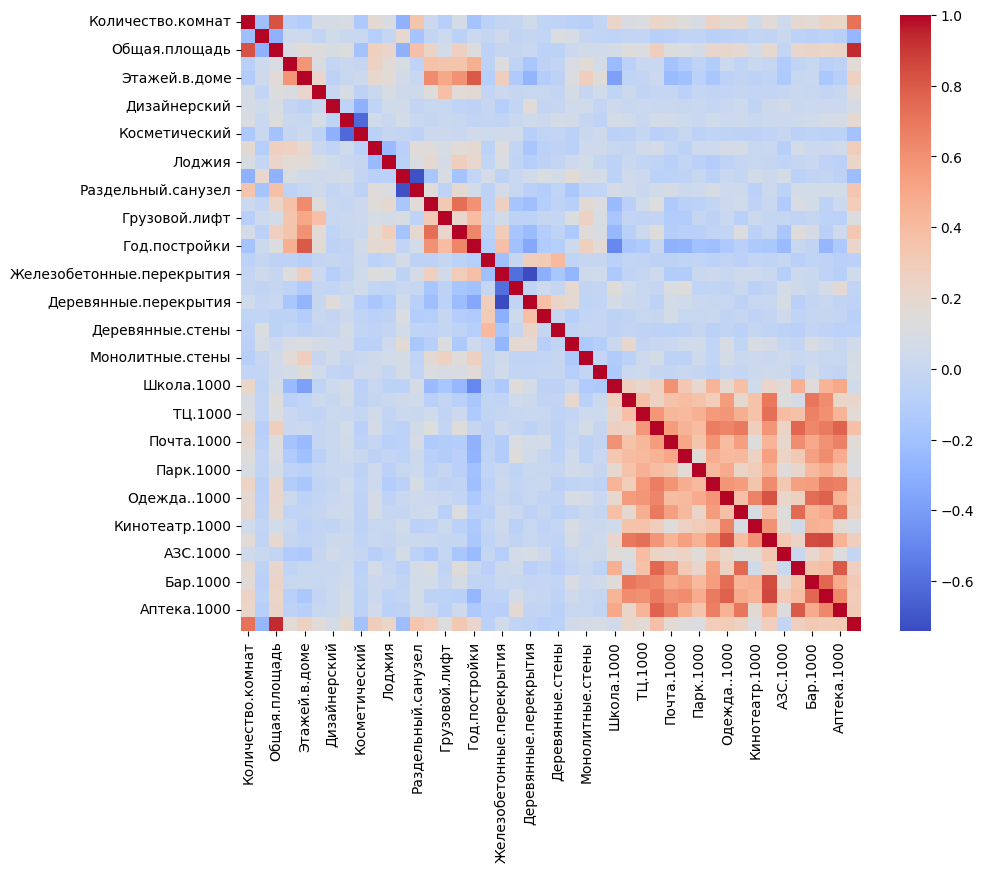

In [12]:
corr_matrix = train_df_reduced.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

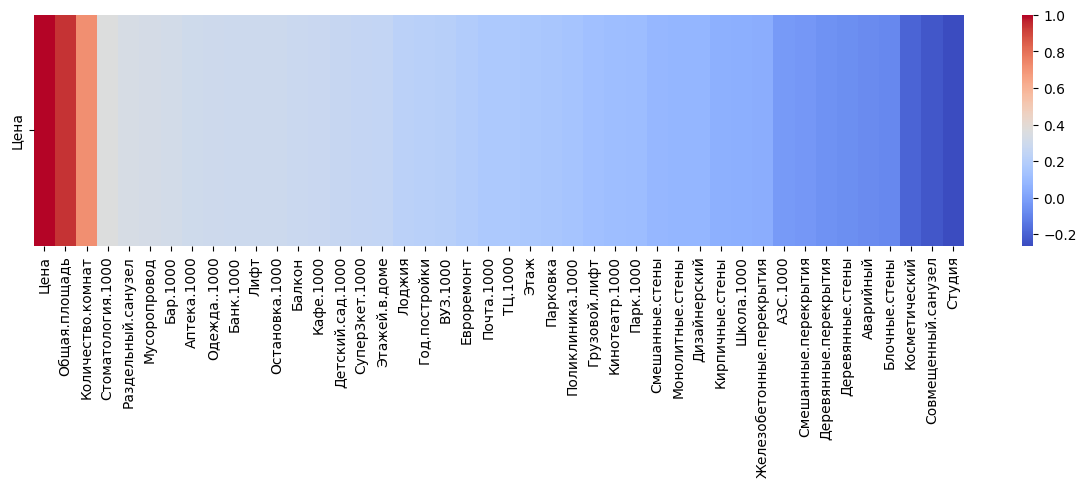

In [13]:
target_correlations = train_df_reduced.corr()['Цена'].sort_values(ascending=False)

target_corr_df = pd.DataFrame(target_correlations).transpose()

plt.figure(figsize=(15, 3))
sns.heatmap(target_corr_df, cmap='coolwarm')
plt.show()

Поиск коррелирующих значений

In [15]:
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j))


weak_corr_with_target = corr_matrix['Цена'][abs(corr_matrix['Цена']) < 0.1].index.tolist()

high_corr_pairs = [(col_i, col_j) for col_i, col_j in high_corr_pairs if 'Цена' not in (col_i, col_j)]


In [16]:
high_corr_pairs

[('Общая.площадь', 'Количество.комнат'),
 ('Кафе.1000', 'Одежда..1000'),
 ('Бар.1000', 'Кафе.1000'),
 ('Банк.1000', 'Кафе.1000')]

In [17]:
weak_corr_with_target

['Дизайнерский',
 'Аварийный',
 'Железобетонные.перекрытия',
 'Смешанные.перекрытия',
 'Деревянные.перекрытия',
 'Блочные.стены',
 'Деревянные.стены',
 'Кирпичные.стены',
 'Монолитные.стены',
 'Смешанные.стены',
 'Школа.1000',
 'АЗС.1000']

In [18]:
features_to_remove_based_on_pairs = {}

for pair in high_corr_pairs:
    if abs(corr_matrix.at[pair[0], 'Цена']) < abs(corr_matrix.at[pair[1], 'Цена']):
        features_to_remove_based_on_pairs[pair[0]] = corr_matrix.at[pair[0], 'Цена']
    else:
        features_to_remove_based_on_pairs[pair[1]] = corr_matrix.at[pair[1], 'Цена']

features_to_remove_based_on_pairs

{'Количество.комнат': 0.715228967783094, 'Кафе.1000': 0.27727471768354306}

HeatMaps после удаления

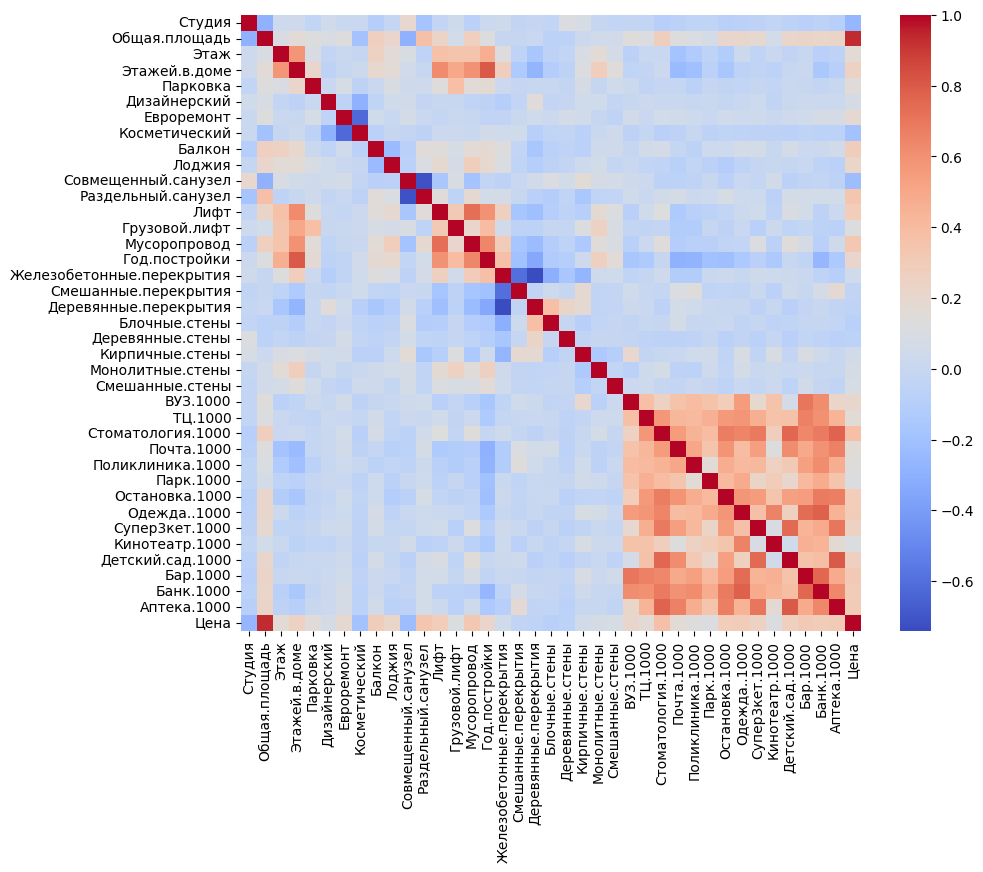

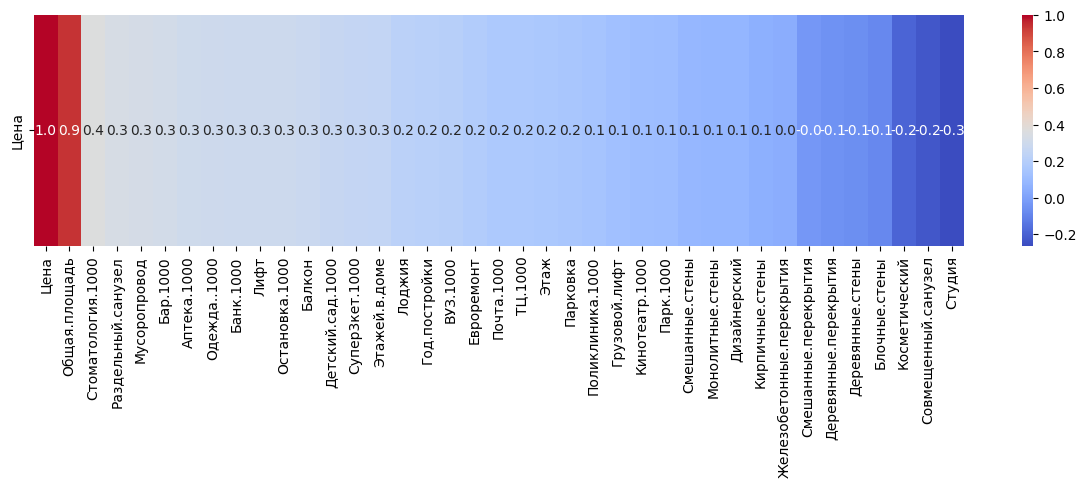

In [19]:
train_df_reduced2 = train_df_reduced.drop(columns=['Количество.комнат','Кафе.1000','Аварийный','Школа.1000','АЗС.1000'])

corr_matrix = train_df_reduced2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()


target_correlations = train_df_reduced2.corr()['Цена'].sort_values(ascending=False)
target_corr_df = pd.DataFrame(target_correlations).transpose()
plt.figure(figsize=(15, 3))
sns.heatmap(target_corr_df, cmap='coolwarm',annot=True,fmt='.1f')
plt.show()

### Модели

In [20]:
X = train_df_reduced2.drop(columns=['Цена'])
y = train_df_reduced2['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included

In [22]:
selected_features = stepwise_selection(X_train, y_train)
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 1. Линейная регрессия (МНК)
mhk = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()

# 2. Лассо регрессия
lasso_regression = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
lasso_r2 = lasso_regression.score(X_test, y_test)

# 3. Гребневая регрессия (Ridge)
ridge_regression = RidgeCV(cv=5).fit(X_train, y_train)
ridge_r2 = ridge_regression.score(X_test, y_test)

# 4. Elastic-Net
elastic_net_regression = ElasticNetCV(cv=5, random_state=42).fit(X_train, y_train)
elastic_net_r2 = elastic_net_regression.score(X_test, y_test)

# 5. Метод наименьших углов (Least-angle regression)
lars_regression = LassoLarsCV(cv=5).fit(X_train, y_train)
lars_r2 = lars_regression.score(X_test, y_test)

# 6. Байесовская регрессия
bayesian_regression = BayesianRidge().fit(X_train, y_train)
bayesian_r2 = bayesian_regression.score(X_test, y_test)

# 7. Обобщенная линейная регрессия
glm_model = GLM(y_train, sm.add_constant(X_train), family=Gaussian()).fit()

# 8. Взвешенный МНК
weights = np.random.rand(len(y_train))
wls_model = sm.WLS(y_train, sm.add_constant(X_train), weights=weights).fit()

# 9. Полиномиальная регрессия
polynomial_features = PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train_selected)
X_test_poly = polynomial_features.transform(X_test_selected)

lm = sm.OLS(y_train, sm.add_constant(X_train_poly)).fit()

# 10. Сплайны
# Определение GAM с использованием сплайнов для каждого признака
if X_train_selected.shape[1] > 0:
    terms = s(0)
    for i in range(1, X_train_selected.shape[1]):
        terms += s(i)
    gam = LinearGAM(terms).fit(X_train_selected, y_train)
    gam_r2 = gam.score(X_test_selected, y_test)

# 11. Непараметрическая регрессия - используем KNeighborsRegressor из sklearn
knn_regression = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
knn_r2 = knn_regression.score(X_test, y_test)

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8144\1978529609.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8144\1978529609.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8144\1978529609.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8144\1978529609.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a d

Информация о моделях

Линейная регрессия (МНК)

In [23]:
mhk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Цена   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1118.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:42:09   Log-Likelihood:                -9068.6
No. Observations:                 646   AIC:                         1.815e+04
Df Residuals:                     638   BIC:                         1.819e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.509e+07   1.24e+06    -12.161      0.000   -1.75e+07   -1.27e+07
Общая.площадь        4.806e+04    659.712     72.848      0.000    4.68e+04    4.94e+04
Стоматология.1000    9901.9181   2495.000      3.969      0.000    5002.513    1.48e+04
Год.постройки        7546.7468    624.635     12.082      0.000    6320.157    8773.336
ВУЗ.1000             1.425e+04   2267.045      6.287      0.000    9800.162    1.87e+04
Остановка.1000       1.907e+04   3170.657      6.016      0.000    1.28e+04    2.53e+04
Евроремонт           2.074e+05   4.12e+04      5.028      0.000    1.26e+05    2.88e+05
Совмещенный.санузел  8.186e+04   2.55e+04      3.213      0.001    3.18e+04    1.32e+05
==============================================================================
Omnibus:                       30.489   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.037
Skew:                          -0.317   Prob(JB):                     6.79e-13
Kurtosis:                       4.296   Cond. No.                     2.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Лассо регрессия

In [24]:
print("Lasso Regression Coefficients:")
for i, coef in enumerate(lasso_regression.coef_):
    print(f"{X_train.columns[i]}: {coef}")
print(f"Intercept: {lasso_regression.intercept_}")
print(f"R^2: {lasso_r2}\n")

r_squared = lasso_r2

# Количество наблюдений и признаков (учитывая, что некоторые коэффициенты могут быть обнулены Лассо)
n = X_train.shape[0]
p = np.sum(lasso_regression.coef_ != 0)

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Остаточная сумма квадратов (RSS)
rss = np.sum((lasso_regression.predict(X_test) - y_test) ** 2)

# Информационный критерий Акаике (AIC)
aic = n * np.log(rss / n) + 2 * (p + 1)

# Байесовский информационный критерий (BIC)
bic = n * np.log(rss / n) + np.log(n) * (p + 1)

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Lasso Regression Coefficients:
Студия: 0.0
Общая.площадь: 47809.71031653995
Этаж: 6357.771575926298
Этажей.в.доме: 4449.178386849076
Парковка: 0.0
Дизайнерский: 0.0
Евроремонт: 0.0
Косметический: -0.0
Балкон: 0.0
Лоджия: 0.0
Совмещенный.санузел: 0.0
Раздельный.санузел: -0.0
Лифт: 0.0
Грузовой.лифт: 0.0
Мусоропровод: -0.0
Год.постройки: 6132.959881085263
Железобетонные.перекрытия: 0.0
Смешанные.перекрытия: -0.0
Деревянные.перекрытия: -0.0
Блочные.стены: -0.0
Деревянные.стены: 0.0
Кирпичные.стены: 0.0
Монолитные.стены: -0.0
Смешанные.стены: 0.0
ВУЗ.1000: 14001.870836908864
ТЦ.1000: -16483.666996570882
Стоматология.1000: 6509.354083328364
Почта.1000: -0.0
Поликлиника.1000: -0.0
Парк.1000: 0.0
Остановка.1000: 17441.47841643916
Одежда..1000: 3019.5712032686824
Супер3кет.1000: 11928.786504462505
Кинотеатр.1000: 0.0
Детский.сад.1000: -1311.7680835012422
Бар.1000: 0.0
Банк.1000: -2618.3057075268375
Аптека.1000: 1122.8846938721817
Intercept: -12280058.150893707
R^2: 0.891339637307479

Adj. R^2:

Гребневая регрессия (Ridge)

In [25]:
print("Ridge Regression Coefficients:")
for i, coef in enumerate(ridge_regression.coef_):
    print(f"{X_train.columns[i]}: {coef}")
print(f"Intercept: {ridge_regression.intercept_}")
print(f"R^2: {ridge_r2}\n")

r_squared = ridge_r2

# Количество наблюдений и признаков
n = X_train.shape[0]
p = len(ridge_regression.coef_)

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Остаточная сумма квадратов (RSS)
rss = np.sum((ridge_regression.predict(X_test) - y_test) ** 2)

# Информационный критерий Акаике (AIC)
aic = n * np.log(rss / n) + 2 * (p + 1)

# Байесовский информационный критерий (BIC)
bic = n * np.log(rss / n) + np.log(n) * (p + 1)

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Ridge Regression Coefficients:
Студия: -33139.32751631059
Общая.площадь: 46877.00444540103
Этаж: 4890.6366311669635
Этажей.в.доме: 1353.269879847131
Парковка: 41708.50319128555
Дизайнерский: 98933.07532006402
Евроремонт: 218988.32736859398
Косметический: 58856.700540587546
Балкон: 21146.00033798513
Лоджия: 72178.02763614335
Совмещенный.санузел: 95424.2863310453
Раздельный.санузел: 57444.04382221119
Лифт: 47985.36480574361
Грузовой.лифт: 35910.85201225869
Мусоропровод: -27726.654980910647
Год.постройки: 5106.584841862958
Железобетонные.перекрытия: -10027.03779297668
Смешанные.перекрытия: -19653.629665757882
Деревянные.перекрытия: -57792.64795784372
Блочные.стены: -26912.7063155691
Деревянные.стены: 39258.11604479723
Кирпичные.стены: 50092.17063392517
Монолитные.стены: 2107.70089151156
Смешанные.стены: 92178.2264161263
ВУЗ.1000: 13773.844197295453
ТЦ.1000: -36118.39777622518
Стоматология.1000: 11726.354348425533
Почта.1000: -4566.112154120492
Поликлиника.1000: 314.72043672868097
Парк.100

Elastic-Net

In [26]:
print("Elastic_net Regression Coefficients:")
for i, coef in enumerate(elastic_net_regression.coef_):
    print(f"{X_train.columns[i]}: {coef}")
print(f"Intercept: {elastic_net_regression.intercept_}")
print(f"R^2: {elastic_net_r2}\n")
r_squared = elastic_net_r2

# Количество наблюдений и признаков
n = X_train.shape[0]
p = np.sum(elastic_net_regression.coef_ != 0)  # Учитываем только ненулевые коэффициенты

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Остаточная сумма квадратов (RSS)
rss = np.sum((elastic_net_regression.predict(X_test) - y_test) ** 2)

# Информационный критерий Акаике (AIC)
aic = n * np.log(rss / n) + 2 * (p + 1)

# Байесовский информационный критерий (BIC)
bic = n * np.log(rss / n) + np.log(n) * (p + 1)

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Elastic_net Regression Coefficients:
Студия: -1.5353350256588494
Общая.площадь: 977.6867377096322
Этаж: 25.32440122594112
Этажей.в.доме: 58.9017553582793
Парковка: 1.7920001208011038
Дизайнерский: 0.0
Евроремонт: 2.280026906053035
Косметический: -3.0879119425133474
Балкон: 7.288728220678072
Лоджия: 4.502036458078879
Совмещенный.санузел: -4.220427981970541
Раздельный.санузел: 7.800242936569275
Лифт: 7.639361080869342
Грузовой.лифт: 0.7989405720722382
Мусоропровод: 7.657152721471689
Год.постройки: 224.7146530584937
Железобетонные.перекрытия: 0.0
Смешанные.перекрытия: -0.0
Деревянные.перекрытия: -0.0
Блочные.стены: -0.0
Деревянные.стены: -0.0
Кирпичные.стены: 0.392587447682951
Монолитные.стены: 0.0
Смешанные.стены: 0.0
ВУЗ.1000: 59.817515999500664
ТЦ.1000: 12.331171880423058
Стоматология.1000: 128.14850203827646
Почта.1000: 11.494612392972519
Поликлиника.1000: 11.394045320790953
Парк.1000: 3.2355898100053984
Остановка.1000: 78.67953225654786
Одежда..1000: 219.54015864811052
Супер3кет.1000

Метод наименьших углов (Least-angle regression)

In [27]:
print("LARS Coefficients:")
for i, coef in enumerate(lars_regression.coef_):
    print(f"{X_train.columns[i]}: {coef}")
print(f"Intercept: {lars_regression.intercept_}")
print(f"R^2: {lars_r2}\n")
r_squared = lars_r2

# Количество наблюдений и признаков
n = X_train.shape[0]
p = np.sum(lars_regression.coef_ != 0)  # Учитываем только ненулевые коэффициенты

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Остаточная сумма квадратов (RSS)
rss = np.sum((lars_regression.predict(X_test) - y_test) ** 2)

# Информационный критерий Акаике (AIC)
aic = n * np.log(rss / n) + 2 * (p + 1)

# Байесовский информационный критерий (BIC)
bic = n * np.log(rss / n) + np.log(n) * (p + 1)

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

LARS Coefficients:
Студия: -20955.85447303455
Общая.площадь: 46851.06675804523
Этаж: 4682.997888468155
Этажей.в.доме: 1620.3926371800478
Парковка: 35175.853437812286
Дизайнерский: 152651.23653799592
Евроремонт: 276859.23014841473
Косметический: 89982.92835053266
Балкон: 19849.39487809389
Лоджия: 70820.37162290375
Совмещенный.санузел: 95258.94682867777
Раздельный.санузел: 58918.237513555476
Лифт: 42683.14194273813
Грузовой.лифт: 31614.61846724824
Мусоропровод: -17125.929220747654
Год.постройки: 5082.251303151482
Железобетонные.перекрытия: 0.0
Смешанные.перекрытия: 0.0
Деревянные.перекрытия: -46911.734197130405
Блочные.стены: 0.0
Деревянные.стены: 0.0
Кирпичные.стены: 49933.84826889908
Монолитные.стены: 0.0
Смешанные.стены: 118943.86303684564
ВУЗ.1000: 13727.077531126813
ТЦ.1000: -34973.820417392744
Стоматология.1000: 11328.477917809767
Почта.1000: -3639.1347117893024
Поликлиника.1000: 0.0
Парк.1000: 9813.385563424736
Остановка.1000: 21687.782321411294
Одежда..1000: 1839.1793760310304
Су

Байесовская регрессия

In [28]:
print("Bayesian Regression Coefficients:")
for i, coef in enumerate(bayesian_regression.coef_):
    print(f"{X_train.columns[i]}: {coef}")
print(f"Intercept: {bayesian_regression.intercept_}")
print(f"R^2: {bayesian_r2}\n")
r_squared = bayesian_r2

# Количество наблюдений и признаков
n = X_train.shape[0]
p = len(bayesian_regression.coef_)

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Остаточная сумма квадратов (RSS)
rss = np.sum((bayesian_regression.predict(X_test) - y_test) ** 2)

# Информационный критерий Акаике (AIC)
aic = n * np.log(rss / n) + 2 * (p + 1)

# Байесовский информационный критерий (BIC)
bic = n * np.log(rss / n) + np.log(n) * (p + 1)

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Bayesian Regression Coefficients:
Студия: -1265.1383523242466
Общая.площадь: 47550.04502965729
Этаж: 6707.326568191937
Этажей.в.доме: 4173.7356453377515
Парковка: 19387.8921823921
Дизайнерский: 7597.606303708826
Евроремонт: 45833.960600951454
Косметический: -11237.473793255896
Балкон: 5670.339128892384
Лоджия: 24004.928886420268
Совмещенный.санузел: 33877.3716988763
Раздельный.санузел: 6169.607376597407
Лифт: 10816.007183754942
Грузовой.лифт: 14092.173470481563
Мусоропровод: -4937.875941775972
Год.постройки: 5522.97891024427
Железобетонные.перекрытия: 3723.5062556099206
Смешанные.перекрытия: -1142.5930285265947
Деревянные.перекрытия: -7006.521584087786
Блочные.стены: -4402.764340722237
Деревянные.стены: 2763.6286392711245
Кирпичные.стены: 20721.69637027713
Монолитные.стены: -594.2710933310725
Смешанные.стены: 8936.72437434297
ВУЗ.1000: 14861.162509939779
ТЦ.1000: -28660.26625163218
Стоматология.1000: 9920.689144591208
Почта.1000: -4779.430358287388
Поликлиника.1000: 41.871420063850685


Обобщенная линейная регрессия


In [29]:
print("GLM Model Summary:")
glm_model.summary()

GLM Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Цена   No. Observations:                  646
Model:                            GLM   Df Residuals:                      607
Model Family:                Gaussian   Df Model:                           38
Link Function:               Identity   Scale:                      8.5803e+10
Method:                          IRLS   Log-Likelihood:                -9028.2
Date:                Tue, 04 Jun 2024   Deviance:                   5.2083e+13
Time:                        15:42:09   Pearson chi2:                 5.21e+13
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -8.814e+06   2.39e+06     -3.684      0.000   -1.35e+07   -4.12e+06
Студия                    -7.582e+04   6.42e+04     -1.181      0.238   -2.02e+05    5.01e+04
Общая.площадь              4.642e+04    751.075     61.806      0.000    4.49e+04    4.79e+04
Этаж                       4036.3010   4014.524      1.005      0.315   -3832.022    1.19e+04
Этажей.в.доме              1084.5415   5167.726      0.210      0.834   -9044.015    1.12e+04
Парковка                   5.108e+04   3.83e+04      1.334      0.182    -2.4e+04    1.26e+05
Дизайнерский               2.546e+05   8.64e+04      2.948      0.003    8.54e+04    4.24e+05
Евроремонт                 3.338e+05   5.55e+04      6.015      0.000    2.25e+05    4.43e+05
Косметический              1.376e+05   4.22e+04      3.264      0.001     5.5e+04     2.2e+05
Балкон                     2.516e+04   2.16e+04      1.163      0.245   -1.72e+04    6.75e+04
Лоджия                     8.137e+04   3.28e+04      2.482      0.013    1.71e+04    1.46e+05
Совмещенный.санузел        9.989e+04   3.54e+04      2.822      0.005    3.05e+04    1.69e+05
Раздельный.санузел         7.622e+04   3.38e+04      2.255      0.024    9986.044    1.42e+05
Лифт                       5.325e+04   3.31e+04      1.610      0.107   -1.16e+04    1.18e+05
Грузовой.лифт              1.962e+04    4.6e+04      0.427      0.670   -7.05e+04     1.1e+05
Мусоропровод              -1.947e+04   4.16e+04     -0.468      0.640   -1.01e+05     6.2e+04
Год.постройки              4582.6343   1197.913      3.826      0.000    2234.768    6930.501
Железобетонные.перекрытия -5.835e+05   2.28e+05     -2.555      0.011   -1.03e+06   -1.36e+05
Смешанные.перекрытия      -6.261e+05   2.41e+05     -2.592      0.010    -1.1e+06   -1.53e+05
Деревянные.перекрытия     -7.019e+05   2.41e+05     -2.910      0.004   -1.17e+06   -2.29e+05
Блочные.стены              4746.5906   1.02e+05      0.047      0.963   -1.95e+05    2.05e+05
Деревянные.стены           3.013e+05   2.26e+05      1.330      0.183   -1.43e+05    7.45e+05
Кирпичные.стены            6.998e+04   3.07e+04      2.279      0.023    9800.984     1.3e+05
Монолитные.стены           3.248e+04   7.12e+04      0.456      0.648   -1.07e+05    1.72e+05
Смешанные.стены            2.032e+05   9.42e+04      2.158      0.031    1.87e+04    3.88e+05
ВУЗ.1000                   1.461e+04   3513.586      4.157      0.000    7718.660    2.15e+04
ТЦ.1000                   -3.671e+04   1.03e+04     -3.549      0.000    -5.7e+04   -1.64e+04
Стоматология.1000          1.278e+04   4561.768      2.802      0.005    3840.167    2.17e+04
Почта.1000                -2405.5131   1.46e+04     -0.165      0.869    -3.1e+04    2.62e+04
Поликлиника.1000            892.9136   9702.474      0.092      0.927   -1.

In [31]:
print(f"AIC: {glm_model.aic}")
print(f"BIC: {glm_model.bic}")

AIC: 18134.30024119074
BIC: 52082577471674.195


c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


Взвешенный МНК

In [ ]:
print("WLS Model Summary:")
wls_model.summary()

WLS Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   Цена   R-squared:                       0.934
Model:                            WLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     226.8
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        03:45:16   Log-Likelihood:                -9115.7
No. Observations:                 646   AIC:                         1.831e+04
Df Residuals:                     607   BIC:                         1.848e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -8.998e+06   2.39e+06     -3.766      0.000   -1.37e+07   -4.31e+06
Студия                    -4.324e+04   6.81e+04     -0.635      0.526   -1.77e+05    9.06e+04
Общая.площадь              4.672e+04    737.801     63.323      0.000    4.53e+04    4.82e+04
Этаж                       6593.8704   3901.050      1.690      0.091   -1067.323    1.43e+04
Этажей.в.доме              -360.4437   5327.971     -0.068      0.946   -1.08e+04    1.01e+04
Парковка                   2.865e+04   3.66e+04      0.782      0.434   -4.33e+04    1.01e+05
Дизайнерский               2.743e+05    8.3e+04      3.306      0.001    1.11e+05    4.37e+05
Евроремонт                 3.428e+05   5.66e+04      6.059      0.000    2.32e+05    4.54e+05
Косметический              1.715e+05   4.52e+04      3.793      0.000    8.27e+04     2.6e+05
Балкон                     5479.1081   2.05e+04      0.267      0.790   -3.48e+04    4.58e+04
Лоджия                     6.185e+04   3.17e+04      1.950      0.052    -438.801    1.24e+05
Совмещенный.санузел        9.028e+04   3.58e+04      2.523      0.012       2e+04    1.61e+05
Раздельный.санузел         5.749e+04   3.42e+04      1.681      0.093   -9665.877    1.25e+05
Лифт                       7.155e+04   3.11e+04      2.299      0.022    1.04e+04    1.33e+05
Грузовой.лифт              6.154e+04   4.73e+04      1.301      0.194   -3.14e+04    1.54e+05
Мусоропровод              -1.364e+04   4.02e+04     -0.339      0.734   -9.26e+04    6.53e+04
Год.постройки              4625.8242   1197.527      3.863      0.000    2274.025    6977.624
Железобетонные.перекрытия -5.196e+05   2.24e+05     -2.320      0.021   -9.59e+05   -7.98e+04
Смешанные.перекрытия      -5.263e+05   2.36e+05     -2.232      0.026   -9.89e+05   -6.31e+04
Деревянные.перекрытия     -6.267e+05   2.39e+05     -2.624      0.009    -1.1e+06   -1.58e+05
Блочные.стены             -4.924e+04   1.08e+05     -0.456      0.649   -2.61e+05    1.63e+05
Деревянные.стены           2.825e+05   1.94e+05      1.460      0.145   -9.75e+04    6.63e+05
Кирпичные.стены            4.945e+04   3.09e+04      1.600      0.110   -1.12e+04     1.1e+05
Монолитные.стены            5.09e+04   7.48e+04      0.681      0.496   -9.59e+04    1.98e+05
Смешанные.стены            1.612e+05   9.01e+04      1.789      0.074   -1.58e+04    3.38e+05
ВУЗ.1000                   1.513e+04   3433.997      4.405      0.000    8381.434    2.19e+04
ТЦ.1000                   -4.199e+04   1.02e+04     -4.122      0.000    -6.2e+04    -2.2e+04
Стоматология.1000          1.258e+04   4436.889      2.835      0.005    3863.162    2.13e+04
Почта.1000                 1590.5880   1.48e+04      0.107      0.915   -2.75e+04    3.07e+04
Поликлиника.1000          -3867.9312   9437.484     -0.410      0.682   -2.

In [ ]:
print(f"AIC: {wls_model.aic}")
print(f"BIC: {wls_model.bic}")

AIC: 18309.396899557018
BIC: 18483.758080204538


Полиномиальная регрессия

In [ ]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Цена   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     282.3
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        03:45:37   Log-Likelihood:                -8994.1
No. Observations:                 646   AIC:                         1.806e+04
Df Residuals:                     611   BIC:                         1.821e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.762e+08   1.37e+08      1.283      0.200   -9.36e+07    4.46e+08
x1         -3.341e+05    7.2e+04     -4.643      0.000   -4.75e+05   -1.93e+05
x2         -9514.3802   3.26e+05     -0.029      0.977    -6.5e+05    6.31e+05
x3         -1.737e+05   1.38e+05     -1.258      0.209   -4.45e+05    9.74e+04
x4          5.348e+05   2.62e+05      2.043      0.041    2.07e+04    1.05e+06
x5         -2.957e+05    3.6e+05     -0.822      0.411      -1e+06    4.11e+05
x6         -1.088e+06   2.16e+06     -0.505      0.614   -5.32e+06    3.15e+06
x7         -4.421e+06    2.6e+06     -1.700      0.090   -9.53e+06    6.86e+05
x8           -97.9208     26.933     -3.636      0.000    -150.814     -45.028
x9           194.5463    136.899      1.421      0.156     -74.302     463.395
x10          193.3399     36.833      5.249      0.000     121.006     265.674
x11          537.3127    124.531      4.315      0.000     292.751     781.874
x12          317.0818    162.766      1.948      0.052      -2.567     636.731
x13         2608.6004   2115.537      1.233      0.218   -1546.005    6763.206
x14         4477.8251   1400.244      3.198      0.001    1727.950    7227.700
x15         -852.5878    355.684     -2.397      0.017   -1551.099    -154.077
x16           14.9823    164.382      0.091      0.927    -307.840     337.805
x17        -1764.1932    592.281     -2.979      0.003   -2927.348    -601.039
x18          126.3743    798.527      0.158      0.874   -1441.816    1694.564
x19        -2346.4210   6985.598     -0.336      0.737   -1.61e+04    1.14e+04
x20         1851.8203   5083.995      0.364      0.716   -8132.404    1.18e+04
x21           42.7892     34.689      1.234      0.218     -25.335     110.914
x22         -261.7491    129.721     -2.018      0.044    -516.503      -6.995
x23          153.4405    181.695      0.844      0.399    -203.383     510.263
x24         1126.9433   2190.054      0.515      0.607   -3174.004    5427.891
x25         2216.2802   1293.971      1.713      0.087    -324.891    4757.451
x26         -726.5553    282.128     -2.575      0.010   -1280.614    -172.496
x27          879.6207    795.984      1.105      0.270    -683.575    2442.816
x28        -2210.4580   5710.678     -0.387      0.699   -1.34e+04    9004.480
x29        -2691.4672   4503.082     -0.598      0.550   -1.15e+04    6151.929
x30         -525.9250    550.420     -0.955      0.340   -1606.869     555.019
x31        -2804.3766   1.03e+04     -0.271      0.786   -2.31e+04    1.75e+04
x32        -4471.8828   6641.938     -0.673      0.501   -1.75e+04    8571.915
x33        -1.088e+06   2.16e+06     -0.505      0.614   -5.32e+06    3.15e+06
x34         5.746e+04      8e+04      0.718      0.473   -9.97e+04    2.15e+05
x35        -1.158e+05   1.79e+05     -0.649      0.517   -4.66e+05    2.35e+05
==

Сплайны. Определение GAM с использованием сплайнов для каждого признака


In [ ]:
print("GAM with Splines Coefficients:")
print(gam.coef_)
print(f"R^2: {gam_r2}\n")
r_squared = gam_r2

# Количество наблюдений и эффективных степеней свободы
n = X_train_selected.shape[0]
edof = gam.statistics_['edof']

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - edof - 1))

aic = gam.statistics_['AIC']

# Остаточная сумма квадратов (RSS)
rss = np.sum((gam.predict(X_train_selected) - y_train) ** 2)
log_likelihood = -n/2 * np.log(2 * np.pi) - n/2 - n/2 * np.log(rss/n)
bic = -2 * log_likelihood + np.log(n) * edof

print(f"Adj. R^2: {adj_r_squared}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

GAM with Splines Coefficients:
[-2477893.13417164 -2314704.75281323 -2169533.82066116 -1861701.56642489
 -1468502.76138168 -1203064.68874827  -918658.92808574  -479674.94150528
  -253746.65284694   -41035.71201467   370076.73721747   612153.70625581
   882073.66244276  1228037.58192781  1713533.52048461  2057656.98148522
  2463454.94118388  2544452.59882278  2226989.29779365  1820499.98360622
   305442.29623605    15625.98352257  -109512.55932944    42905.9682319
   162331.51323274    86322.63317216   136434.37510862   214451.98619411
   234367.63505725   163124.52073367   165204.51258935   170231.69189597
   260585.17045404   226986.92803484   237877.16924338   208153.42782068
   138088.75356613    78580.38339847    23674.44669521   -30465.03580322
    96083.18795591   128454.14485374   128222.53444969    43213.18455855
  -109260.11073014  -197450.28117864  -173669.73413428   -96132.6800758
    60653.0382897     39337.71292035    54807.03460062   193926.58586829
    42213.37461226    

Непараметрическая регрессия - используем KNeighborsRegressor из sklearn

In [ ]:
print(f"KNN Regression R^2: {knn_r2}\n")
r_squared = knn_r2

# Количество наблюдений и признаков
n = X_train.shape[0]
p = X_train.shape[1]

# Скорректированный коэффициент детерминации (Adj. R^2)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

print(f"KNN Regression Adj. R^2: {adj_r_squared}")

KNN Regression R^2: 0.8642902380024762

KNN Regression Adj. R^2: 0.8557944044672111


Предсказание

In [ ]:
test_df_reduced = test_df.drop(columns=['Без.ремонта','Панельные.стены','Иные.перекрытия'])

In [ ]:
test_df_reduced2 = test_df_reduced.drop(columns=['Количество.комнат','Кафе.1000','Аварийный','Школа.1000','АЗС.1000'])

In [ ]:
# Исключаем столбец Id из тестовых данных для предсказания
X_test = test_df_reduced2.drop(columns=['id'])

# Получаем предсказания от модели
predictions = glm_model.predict(sm.add_constant(X_test))

# Сопоставляем предсказания с Id
submission = pd.DataFrame({
    'id': test_df['id'],
    'Цена': predictions
})

# Сохраняем предсказания в CSV файл
submission.to_csv('submission.csv', index=False)